In [1]:
from IPython.display import clear_output
import random as rnd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt 
import time
import math


#import Rounds and Game creating classes
%run RollsPlayersRounds.ipynb
#import Rule based Agent
%run RuleBasedAgent.ipynb
#import Monte Carlo Random Rollout Player
%run MCTSAgent.ipynb
#import Probabilistic
%run ProbabilisticAgent.ipynb
    
    
#Scalar and Scoring
scalar = 2
scoring = [-1,0,0]

# Experiment 3 - Comparison of all Agents
## 1) Rounds

In [28]:
losses = {}
Game = full_game(4, Human=False, shuffle = False)
for x in Game.Players:
    losses[x] = 0
for i in range(400):
    first_player = rnd.choice(Game.Players)
    roundd = rounds(Game.diceState, Game.Players, first_player, Game.human, shuffle=True)
    t0 = time.time()
    while roundd.last != 'Dudo' and roundd.last != 'Calza':

        # Play a round
        if roundd.player == 'Martha':
            agent = probabilistic_agent(roundd.total_dice, roundd.rolls[roundd.player], 
                                        last_bid = roundd.last)
            bid = agent.make_bid()
        elif roundd.player == 'Lorenzo':
            #Random Rollout
            dice_state_opponents = Game.diceState.copy()
            del dice_state_opponents['Lorenzo']
            agent = MCTSPlayer(MOVES,scalar,len(roundd.Players), roundd.rolls[roundd.player], 
                                 roundd.total_dice,roundd.Players, roundd.player, dice_state_opponents,
                               roundd.history,scoring, previous_bid = roundd.last,
                               Random = True, smart_rollouts = True)
            bid = agent.chooseMove()
        elif roundd.player == 'Maria':
            agent = rule_based_agent(roundd.rolls[roundd.player],roundd.last, 
                                     roundd.history, roundd.total_dice, roundd.Players)
            bid = agent.make_bid()
        elif roundd.player == 'Manuel':
            #observer agent rollout
            dice_state_opponents = Game.diceState.copy()
            del dice_state_opponents['Manuel']
            agent = MCTSPlayer(MOVES,scalar,len(roundd.Players), roundd.rolls[roundd.player], 
                                 roundd.total_dice,roundd.Players, roundd.player, dice_state_opponents,
                               roundd.history, scoring,previous_bid = roundd.last,
                               Random = False , smart_rollouts = True)
            bid = agent.chooseMove()
            
    
        roundd.last = bid
        roundd.history.append(bid)

        #Analyse terminal bid and update dice accordingly
        if roundd.last == 'Dudo': 
            t1 = time.time()
            print ('time: ', t1-t0)
            loser_winner = roundd.call()
            for i in roundd.Players:
                if loser_winner[0] == i:
                    losses[i] +=1
            break

        elif roundd.last == 'Calza':
            t1= time.time()
            print ('time: ', t1-t0)
            loser_winner = roundd.call(Dudo = False, Calza = True)
            if loser_winner[1] == 1:
                for i in roundd.Players:
                    if loser_winner[0] == i:
                        losses[i] -=1
            else:
                for i in roundd.Players:
                    if loser_winner[0] == i:
                        losses[i] +=1
            break        
        else:
            roundd.next_player()

clear_output()
print (losses)

{'Martha': 116, 'Lorenzo': 104, 'Maria': 84, 'Manuel': 96}


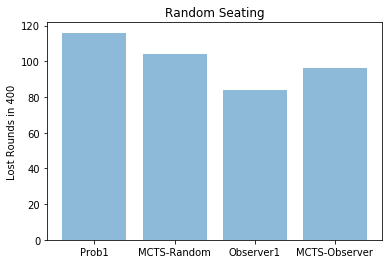

In [30]:
names = [n for n in losses]
x = ['Prob1', 'MCTS-Random', 'Observer1', 'MCTS-Observer']
y_pos = np.arange(len(x))
performance = []
for i in names:
    performance.append(losses[i])
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, x)
plt.ylabel('Lost Rounds in 400')
plt.title('Random Seating')
plt.savefig('Experiment 3a1')
plt.show()

## 2) Full Games

In [52]:
wins = {}
wins['Martha']=wins['Lorenzo']=wins['Maria']=wins['Manuel'] = 0
for i in range(200):
    Game = full_game(4, Human=False, shuffle = True)
    while len(Game.Players) > 1:
        roundd = rounds(Game.diceState, Game.Players, Game.player, Game.human, shuffle=False)
        while roundd.last != 'Dudo' and roundd.last != 'Calza':
        # Play a round
            if roundd.player == 'Martha':
                agent = probabilistic_agent(roundd.total_dice, roundd.rolls[roundd.player], 
                                            last_bid = roundd.last)
                bid = agent.make_bid()
            elif roundd.player == 'Lorenzo':
                #Random Rollouts
                dice_state_opponents = Game.diceState.copy()
                del dice_state_opponents['Lorenzo']
                agent = MCTSPlayer(MOVES,scalar,len(roundd.Players), roundd.rolls[roundd.player], 
                                 roundd.total_dice,roundd.Players, roundd.player, dice_state_opponents,
                               roundd.history,scoring, previous_bid = roundd.last,
                               Random = True, smart_rollouts = True)
                bid = agent.chooseMove()
            elif roundd.player == 'Maria':
                agent = rule_based_agent(roundd.rolls[roundd.player],roundd.last, 
                                     roundd.history, roundd.total_dice, roundd.Players)
                bid = agent.make_bid()
            elif roundd.player == 'Manuel':
                #Observer Rollout
                dice_state_opponents = Game.diceState.copy()
                del dice_state_opponents['Manuel']
                agent = MCTSPlayer(MOVES,scalar,len(roundd.Players), roundd.rolls[roundd.player], 
                                     roundd.total_dice,roundd.Players, roundd.player, dice_state_opponents,
                                   roundd.history,scoring, previous_bid = roundd.last,
                                   Random = False, smart_rollouts = True)
                bid = agent.chooseMove()
    

            roundd.last = bid
            roundd.history.append(bid)

            #Analyse terminal bid and update dice accordingly
            if roundd.last == 'Dudo': 
                loser_winner = roundd.call()
                Game.update_dice_players(loser_winner[0], loser_winner[1])

            elif roundd.last == 'Calza':
                loser_winner = roundd.call(Dudo = False, Calza = True)
                if loser_winner[1]==1:
                    Game.update_dice_players(loser_winner[0], loser_winner[1])
                else:
                    Game.update_dice_players(loser_winner[0], loser_winner[1])
            else:
                roundd.next_player()
                
    if len(Game.Players) == 1:
        wins[Game.Players[0]] +=1

clear_output()
print (wins)


{'Martha': 29, 'Lorenzo': 50, 'Maria': 51, 'Manuel': 70}


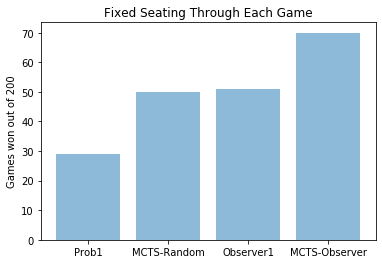

In [53]:
names = [n for n in wins]
x = ['Prob1', 'MCTS-Random', 'Observer1', 'MCTS-Observer']
y_pos = np.arange(len(x))
performance = []
for i in names:
    performance.append(wins[i])
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, x)
plt.ylabel('Games won out of 200')
plt.title('Fixed Seating Through Each Game')
plt.savefig('Experiment 3b1')
plt.show()